# 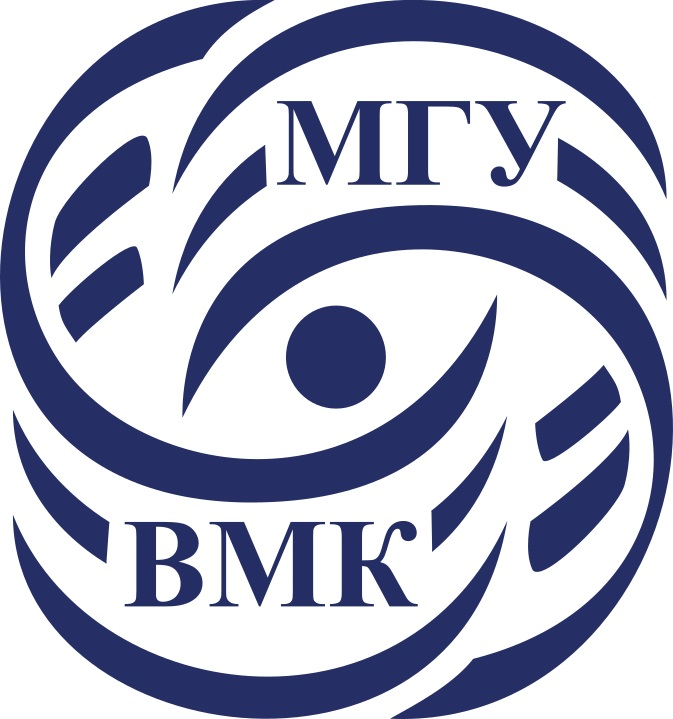

# Машинное обучение. ВМК МГУ

## Практическое задание 4: Линейные модели, часть 1: Регрессия

### Важно! О формате сдачи

* Все задания в этой части оцениваются по системе <font color='red'>кросс-рецензирования.</font>
* При решении ноутбука <font color='red'>используйте данный шаблон.</font> Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно
* Везде, где в формулировке задания есть <font color='red'>какой-либо вопрос (или просьба вывода)</font>, необходимо прописать ответ в ячейку (код или markdown).
* Наличие <font color='red'>кода решения обязательно.</font> Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.
* Если в ячейке написана фраза <font color='red'>"Вывод"/"Ответ на вопрос" итд</font>, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано <font color='red'>"Your code here" и пр. </font>, то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст

Цель данного задания:

* Узнать, что такое переобучение и как с ним бороться в линейных моделях;
* Понять, чем отличаются разные регуляризаторы;
* Научиться решать задачу регрессии линейными моделями.
-------
При выполнении данного задания необходимо последовательно запустить все ячейки ноутбука и ответить на $11$ вопросов. Ответы на вопросы будут проверены в рамках кросс-ревью. Всего за ответы на вопросы можно получить $20$ баллов.

### <font color=orange>*Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: 30 минут </font>*

## Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

**Важно!**
Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

**Важно!**
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-23-24/blob/main/tutorials/Туториал%20по%20установке%20рабочего%20окружения%20в%20Python%20для%20решения%20задач.pdf)


In [ ]:
# !!! Данный блок будет работать только в Google-Colab !!!
# Устанавливаем урезанную версию requeirements.txt для ускорения установки
# Если будут всплывать ошибки о несовместимости библиотек, то ничего страшного
# На это задание они не влияют

! gdown 1pIw8GdGKY6fZ_XNPc6snimdV6lbXJ199
! pip install -r /content/requirements_small.txt

In [ ]:
import catboost
assert(catboost.__version__ == '1.2.1')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2023"></font>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
sns.set(style="darkgrid")
%matplotlib inline

## Часть 1. Линейная регрессия

Напомним, что линейная регрессия — это модель следующего вида: $$a(x) = \langle w, x \rangle + b$$ где $w \in \mathbb{R}^d$, $b \in \mathbb{R}$. Обучить линейную регрессию — значит найти $w$ и $b$.

Для обучения линейной регрессии, равно как и для обучения остальных простых моделей (линейные модели, решающие деревья, knn и т.д.) отлично подходит библиотека scikit-learn (sklearn): в ней очень понятный и простой интерфейс.

Однако для обучения более сложных моделей вроде бустинга и нейронных сетей всё же нужно пользоваться специализированными библиотеками: XGBoost, LightGBM, CatBoost и пр. для градиентного бустинга над деревьями, PyTorch, Tensorflow и пр. для нейронных сетей.

Так как мы будем обучать линейную регрессию, нам подойдет реализация из sklearn. В sklearn есть несколько классов, реализующих линейную регрессию. Основные это:

- Ridge — линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией
- Lasso — линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией

Также есть SVR, ElasticNet  и пр., но не будем сегодня о них

У моделей из sklearn есть методы fit и predict. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке.

Рассмотрим, модельные данные для задачи регрессии. Пусть $x$ будет обычным числом из равномерного распределения, а $y = 0.5 \cdot x + 0.1$ &mdash; целевая переменная. При этом наблюдаем мы $\overline{y} = y + \varepsilon,~\varepsilon \sim \mathcal{N}(0, 0.01)$.

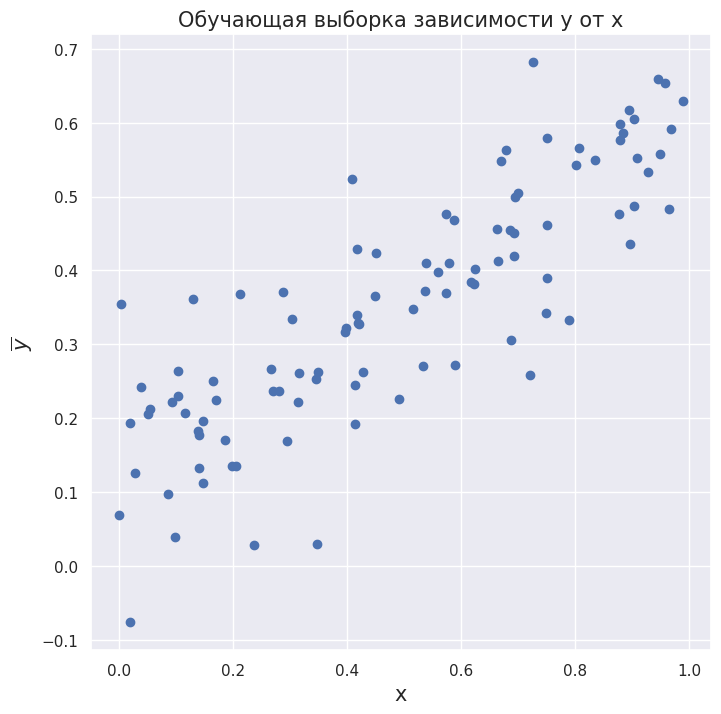

In [ ]:
np.random.seed(1)
X = np.random.uniform(0, 1, 100)
Y = X * 0.5 + 0.1 + np.random.randn(100) * 0.1

plt.figure(figsize=(8, 8))
plt.scatter(X, Y)
plt.title("Обучающая выборка зависимости y от x", size=15)
plt.xlabel("x", size=15)
plt.ylabel(r'$\overline{y}$', size=15)
plt.show()

Обучим линейную регрессию, и посмотрим как регуляризация влияет на качество модели. В реализации библиотеки sklearn коэффициент регуляризации задаётся параметром alpha

In [ ]:
from sklearn.linear_model import Ridge

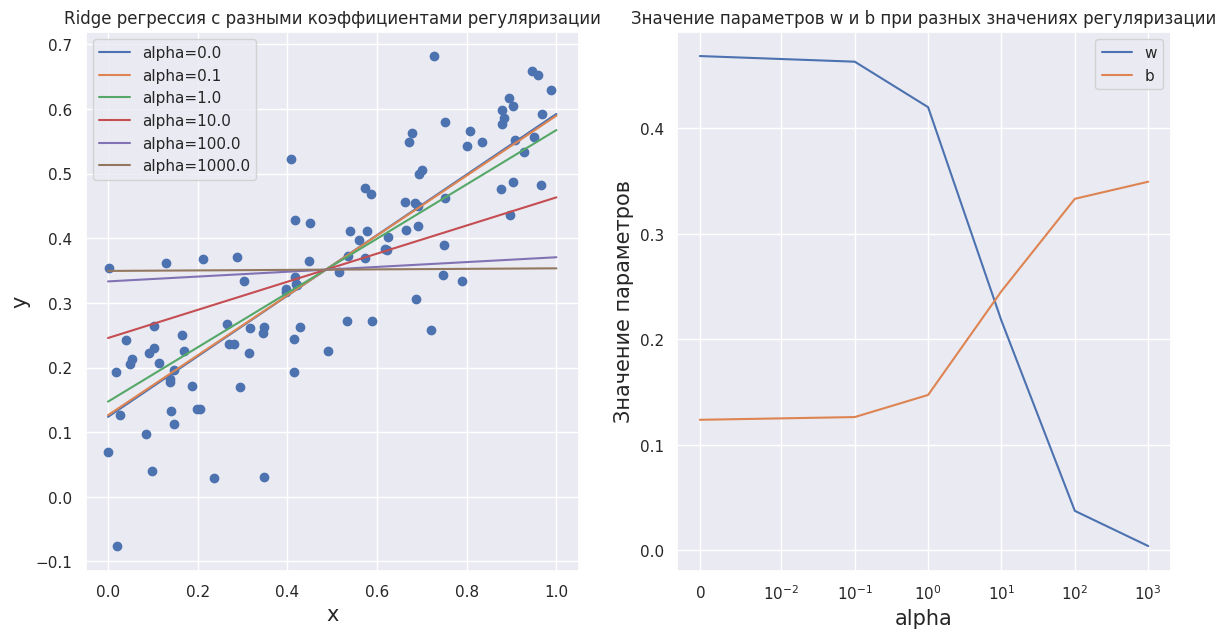

In [ ]:
x_axis = np.linspace(0, 1, 200)
fig, axs = plt.subplots(figsize=(14, 7), ncols=2)
axs[0].scatter(X, Y)

w = []
b = []

alphas = [0.0, 0.1, 1.0, 10.0, 100.0, 1000.0]

for alpha in alphas:
    reg = Ridge(alpha=alpha)
    reg.fit(X[:, None], Y)
    pred = reg.predict(x_axis[:, None])
    w.append(reg.coef_[0])
    b.append(reg.intercept_)
    axs[0].plot(x_axis, pred, label="alpha=" + str(alpha))

axs[0].legend()
axs[0].set_xlabel("x", size=15)
axs[0].set_ylabel("y", size=15)
axs[0].set_title("Ridge регрессия с разными коэффициентами регуляризации")
axs[1].plot(alphas, w, label="w")
axs[1].plot(alphas, b, label="b")
axs[1].set_xlabel("alpha", size=15)
axs[1].set_ylabel("Значение параметров", size=15)
axs[1].set_title("Значение параметров w и b при разных значениях регуляризации")
axs[1].set_xscale("symlog", linthresh=0.01)
axs[1].legend()
plt.show()

### **Вопрос 1** (1 балл)

Как зависят параметры модели от константы регуляризации? А качество?



***Ваш ответ здесь***  
Чем больше константа регуляризации, тем больше штраф за значения параметров. Качество модели, в свою очередь, зависит от следующих факторов:

*   При увеличении константы регуляризации, у модели может возникнуть проблема потери обобщающей способности, что можно наблюдать на графиках при α ≥ 100.
*   При уменьшении константы регуляризации возможно переобучение модели.

Таким образом, при выборе оптимальной константы регуляризация помогает решить проблемы мультиколлинеарности и переобучения.

### **Вопрос 2** (1 балл)

Почему при обучении линейных моделей, коэффициент $b$ не регуляризуется? Дайте ответ с опорой на лекции и увиденные картинки.

***Ваш ответ здесь***  
Коэффициент $b$ в линейных моделях отвечает за **смещение линии регрессии**. Не регуляризуют его, потому что это не имеет смысла: если даже все значения $y$ **равномерно велики**, это не негативно сказывается на **качестве обучения**.

------

Казалось бы, зачем нам эта глупая регуляризация?!

Давайте рассмотрим ещё один модельный пример. Представим, что кто-то добавил в данные к переменной $x$ её же умноженную на $2$. То есть, теперь у нас два признака $x_1$ и $x_2 = 2 \cdot x_1$. Тогда, $y = c \cdot 0.5 \cdot x_1 + \frac{1 - c}{4} \cdot x_2 + 0.1$, где $c$ любое сколь угодно большое вещественное число. Это может привести к тому, что без регуляризации мы рискуем выучить очень большие веса!

In [ ]:
np.random.seed(1)
X2 = np.hstack((X[:, None], 2 * X[:, None]))
Y2 = X2[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

reg = Ridge(alpha=0.0)
reg.fit(X2, Y2)
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

w1: 0.1006220738265918 	w2: 0.20124414765318363


Коэффициенты адекватные, хотя и не похожи на изначальную зависимость. Но что, если $x_2$ будет равняться $3 \cdot x_1$?

In [ ]:
np.random.seed(1)
X3 = np.hstack((X[:, None], 3 * X[:, None]))
Y3 = X3[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

reg = Ridge(alpha=0.0)
reg.fit(X3, Y3)
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

w1: 20443435586638.348 	w2: -6814478528879.28


Тут вот уже не повезло. Коэффициенты случайно выучились неадекватно большими. Создадим обучающую выборку из того же распределения и посмотрим на качество

In [ ]:
np.random.seed(2)
X3_test = np.random.uniform(0, 1, 100)
X3_test = np.hstack((X3_test[:, None], 3 * X3_test[:, None]))
Y3_test = X3_test[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

Y3_test_pred = np.sum(reg.coef_[None] * X3_test + reg.intercept_, axis=1)
print("MSE loss: %.4f" % np.mean((Y3_test_pred - Y3_test) ** 2))

MSE loss: 0.0209


Вроде бы неплохое, но что если мы добавим ко второму признаку одного из объектов небольшой шум?

In [ ]:
X3_test[0, 1] = X3_test[0, 1] + 1e-10
Y3_test_pred_noisy = np.sum(reg.coef_[None] * X3_test + reg.intercept_, axis=1)
print("MSE loss:", np.mean((Y3_test_pred_noisy - Y3_test) ** 2))
print("Предсказание для первого объекта с шумом: ", Y3_test_pred_noisy[0])
print("Предсказание для первого объекта без шума: ", Y3_test_pred[0])

MSE loss: 4641.705892708396
Предсказание для первого объекта с шумом:  -681.02734375
Предсказание для первого объекта без шума:  0.419921875


Как видим, даже небольшое изменение в данных, приводит к резкому падению качества.

### **Вопрос 3** (2 балла)
Рассмотрите больше примеров с двумя признаками $x_1$ и $x_2$, где $x_2$ линейно зависит от $x_1$. Убедитесь, что линейная модель без регуляризации крайне неустойчива.

In [ ]:
np.random.seed(1)

X4_train = np.random.uniform(0, 1, 100)
X4_test = np.random.uniform(0, 1, 100)

k = [1, 5, 10, 15, 20, 25, 50]

for ratio in k:
  X4_train_ratio = np.hstack((X4_train[:, None], ratio * X4_train[:, None]))
  Y4_train = X4_train_ratio[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

  reg = Ridge(alpha=0.0)
  reg.fit(X4_train_ratio, Y4_train)

  print("-------------\n",
   f"x2 = {ratio} * x1\nw1 = {reg.coef_[0]}, w2 = {reg.coef_[1]}")

  X4_test_ratio = np.hstack((X4_test[:, None], ratio * X4_test[:, None]))
  Y4_test = X4_test_ratio[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

  Y4_test_pred = np.sum(reg.coef_[None] * X4_test_ratio + reg.intercept_, axis=1)

  X4_test_ratio[0, 1] = X4_test_ratio[0, 1] + 1e-10
  Y4_test_pred_noise = np.sum(reg.coef_[None] * X4_test_ratio + reg.intercept_, axis=1)

  print("MSE loss с шумом: ", np.mean((Y4_test_pred_noise - Y4_test) ** 2))
  print("MSE loss без шума: ", np.mean((Y4_test_pred - Y4_test) ** 2))
  print("Предсказание для первого объекта с шумом: ", Y4_test_pred_noise[0])
  print("Предсказание для первого объекта без шума", Y4_test_pred[0])


-------------
 x2 = 1 * x1
w1 = 0.24284173797166947, w2 = 0.24284173797166958
MSE loss с шумом:  0.0256890791771566
MSE loss без шума:  0.025689079177124142
Предсказание для первого объекта с шумом:  0.3919999943367819
Предсказание для первого объекта без шума 0.39199999431249777
-------------
 x2 = 5 * x1
w1 = -1437026291468.5688, w2 = 287405258293.8024
MSE loss с шумом:  8.420554134939568
MSE loss без шума:  0.027725429407189594
Предсказание для первого объекта с шумом:  29.14947509765625
Предсказание для первого объекта без шума 0.408935546875
-------------
 x2 = 10 * x1
w1 = -5787758263740.054, w2 = 578775826374.055
MSE loss с шумом:  33.888813578990245
MSE loss без шума:  0.027913197841708526
Предсказание для первого объекта с шумом:  58.264404296875
Предсказание для первого объекта без шума 0.38671875
-------------
 x2 = 15 * x1
w1 = 35279612504738.516, w2 = -2351974166982.5337
MSE loss с шумом:  552.3431048224608
MSE loss без шума:  0.017013207527993766
Предсказание для первого 

-----

Теперь добавим регуляризацию и посмотрим, как меняется значения весов, в зависимости от значения коэффициента регуляризации.

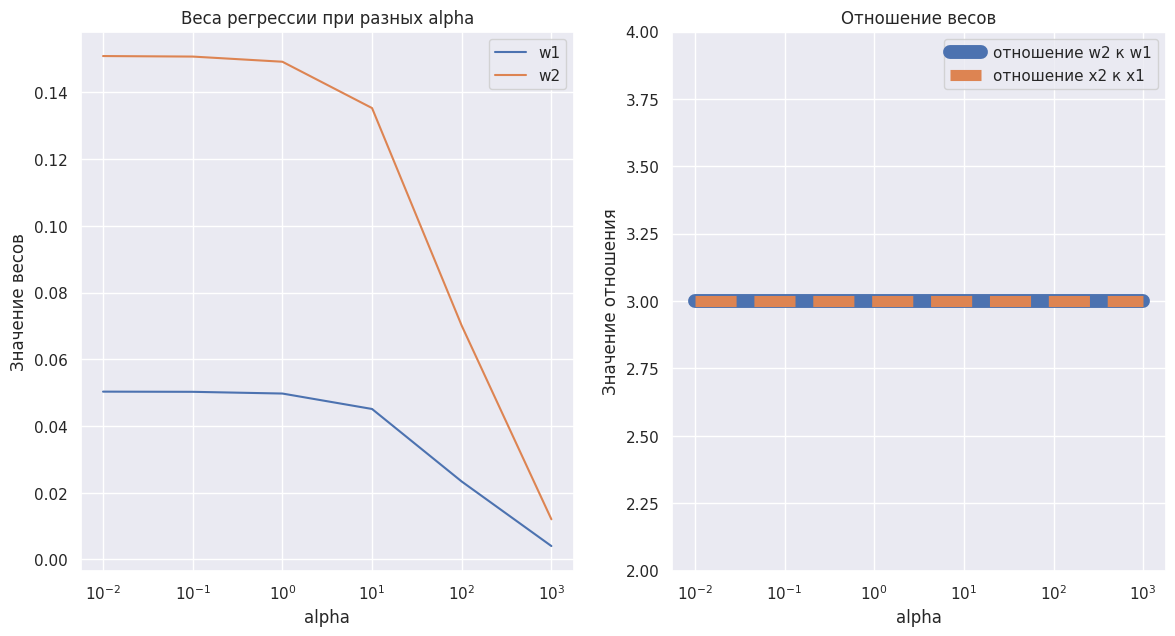

In [ ]:
w1 = []
w2 = []

alphas = [0.01, 0.1, 1, 10, 100, 1000]

for alpha in alphas:
    reg = Ridge(alpha=alpha)
    reg.fit(X3, Y3)
    w1.append(reg.coef_[0])
    w2.append(reg.coef_[1])

w1 = np.array(w1)
w2 = np.array(w2)

fig, axs = plt.subplots(figsize=(14, 7), ncols=2)
axs[0].plot(alphas, w1, label="w1")
axs[0].plot(alphas, w2, label="w2")
axs[0].set_xscale("log")
axs[0].set_title("Веса регрессии при разных alpha")
axs[0].set_xlabel("alpha")
axs[0].set_ylabel("Значение весов")
axs[0].legend()
axs[1].plot(alphas, w2 / w1, label="отношение w2 к w1", linewidth=10)
axs[1].plot([0.01, 1000], [3, 3], label="отношение x2 к x1", linestyle="--", linewidth=8)
axs[1].set_xscale("log")
axs[1].set_ylim(2,4)
axs[1].set_xlabel("alpha")
axs[1].set_ylabel("Значение отношения")
axs[1].set_title("Отношение весов")
axs[1].legend()
plt.show()

### **Вопрос 4** (2 балла)

Как думаете, почему отношение между весами постоянно? (подсказка, необходимо выписать функцию потерь и посчитать производные по весам)

**Ваш ответ здесь**  

Пусть $x_2 = c ⋅ x_1$, тогда для нашего примера распишем:
$$L(f_w, X, y) = \frac{1}{N}\sum_i ||Xw - y||_2^2 + \alpha|w|^2$$

$$\frac{\partial L}{\partial w_j} = \frac{1}{N}\sum_i 2 x_{ij} (w_1x_{i1} + w_2x_{i2} - y_i) + 2\alpha w_i
, j = 0, 1 $$
Причём каждая из частных производных (по необходимому условию экстремума) равна нулю, так как задача регресии $-$ задача минимизации функции потерь.  
Имеем:

$$ \begin{cases}
\sum_i x_{i1} (w_1x_{i1} + w_2x_{i2} - y_i) = -\alpha N w_1 \\
\sum_i x_{i2} (w_1x_{i1} + w_2x_{i2} - y_i) = -\alpha N w_2
\end{cases} $$

Подставим $x_2 = c ⋅ x_1$ и получим:

$$ \begin{cases}
\sum_i x_{i1} (w_1x_{i1} + w_2x_{i2} - y_i) = -\alpha N w_1 \\
c \sum_i x_{i1} (w_1x_{i1} + w_2x_{i2} - y_i) = -\alpha N w_2
\end{cases} $$

Разделим второе уравнение на первое и, наконец, найдём искомое соотношение:  
$$\frac {w_2} {w_1} = \frac {x_2} {x_1} = c$$

-----
<font color="white" style="opacity:0.2023"></font>

Заметим, что при $l_2$ регуляризации в данном примере веса получились пропорциональны значениям признаков. При этом, мы знаем, что оба признака взаимно однозначны, и прогноз можно делать только по одному из них. Для этого придумана $l_1$ регуляризация. В билиотеке sklearn линейная регрессия с $l_1$ регуляризацией реализована в классе Lasso

### **Вопрос 5** (2 балла)

Почему в нашем примере $l_1$ регуляризация приведёт к разреживанию весов? (подсказка, нужно опять подсчитать производную, но обратите внимание на дифференцируемость модуля).

**Ваш ответ здесь**  
Пусть ни один из весов не обнулился. Докажем от противного:
$$L(f_w, X, y) = \frac{1}{N}\sum_i ||Xw - y||_2^2 + \alpha|w|$$

$$\frac{\partial L}{\partial w_j} = \frac{1}{N}\sum_i 2 x_{ij} (w_1x_{i1} + w_2x_{i2} - y_i) + \alpha \cdot sign(w_j)
, j = 0, 1 $$

Причём, формула выше верна при $w_i \ne 0$.
$$ \begin{cases}
\sum_i x_{i1} (w_1x_{i1} + w_2x_{i2} - y_i) = \frac{-\alpha N}{2} sign(w_1) \\
\sum_i x_{i2} (w_1x_{i1} + w_2x_{i2} - y_i) = \frac{-\alpha N}{2} sign(w_2)
\end{cases} $$

Аналогично предыдущему, получим:

$$\frac {sign(w_2)} {sign(w_1)} = c = \frac {x_2} {x_1}$$
Что в общем случае неверно $\Rightarrow$ противоречие $\Rightarrow$ один из весов нулевой.

-----

Добавим $l_1$ регуляризацию и посмотрим, как меняется значения весов, в зависимости от значения коэффициента регуляризации.

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
reg = Lasso(alpha=1., max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 1.")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.1, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.1")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.01, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.01")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.001, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.0001, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.0001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.00001, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.00001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

Веса, при alpha = 1.
w1: 0.0 	w2: 0.0

Веса, при alpha = 0.1
w1: 0.0 	w2: 0.03950662786303303

Веса, при alpha = 0.01
w1: 0.0 	w2: 0.15488377352619098

Веса, при alpha = 0.001
w1: 0.0 	w2: 0.1664214880925068

Веса, при alpha = 0.0001
w1: 0.0 	w2: 0.1675752595491384

Веса, при alpha = 0.00001
w1: 0.4261538129756522 	w2: 0.025639365702917725



### **Вопрос 6** (2 балла)

Почему в итоге при $\alpha = 0.00001$ получились веса не равные нулю?


**Подсказка** Обратите внимание на то, каким странным получился вес $w_2$

**Ваш ответ здесь**   
В примере выше при α = 0.00001 выставлены max_iter = 1000, tol=1e-4.
Скорость сходимости градиентного спуска напрямую зависит от константы регуляризации. А при увеличении количества итераций сможем обнулить первый вес.

In [ ]:
reg = Lasso(alpha=0.00001, max_iter=10000, tol=1e-4)
reg.fit(X3, Y3)

print("w1 =", reg.coef_[0])
print("w2 =", reg.coef_[1])

w1 = 0.0
w2 = 0.1676906366948017


-----

В предущих блоках мы использовали модельные примеры, в которых $y$ зависел от $x$ линейно. Но так бывает далеко не всегда.

### **Вопрос 7** (2 балла)

 Придумайте, сгенерируйте и визуализируйте пример, в котором линейная регрессия будет плохо классифицировать данные.

MSE loss: 24.6209



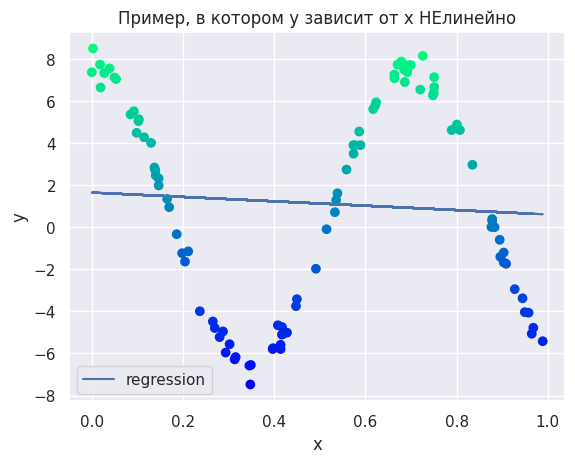

In [ ]:
np.random.seed(1)
X_test = np.random.uniform(0, 1, 100).reshape(-1, 1)
Y_test = 7 * np.cos(9 * X_test[:, 0]) + 0.5 + np.random.randn(100) * 0.4

reg = Ridge(alpha=0)
reg.fit(X_test, Y_test)

Y_test_pred = np.sum(reg.coef_[None] * X_test + reg.intercept_, axis=1)
print("MSE loss: %.4f\n" % np.mean((Y_test_pred - Y_test) ** 2))

plt.plot(X_test[:, 0], Y_test_pred, label='regression')
plt.scatter(X_test[:, 0], Y_test, c=Y_test, cmap='winter')
plt.xlabel("x")
plt.ylabel("y")
plt.title('Пример, в котором y зависит от x НЕлинейно')
plt.legend()

-------------

Попробуем обучить линейную регрессию c $l_1$ регуляризацией на специальном датасете из sklearn

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023)

Взглянем немножко на данные. Выведем средние значения каждого признака

In [ ]:
with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
  print(X_train.mean(axis=0))

[ 3.871  28.668  5.438  1.097  1423.264  3.116  35.621 -119.558]


Нетрудно видеть, что масштаб у разных признаков сильно отличается. Это может приводить к разным неприятным эффектам. Подробнее эту проблему мы разберём в следующем задании.

In [ ]:
from sklearn.preprocessing import StandardScaler

### **Вопрос 8** (2 балла)

Отмасштабируйте данные при помощи класса StandardScaler. Выведите средние значения и дисперсии признаков на обучающей и тестовой выборках.

**Замечание:** Результат положите в переменные X_train_scaled и X_test_scaled , чтобы последующий код был рабочим

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
    print(f'train, mean:\t{scaler.mean_}')
    print(f'test, mean:\t{X_test.mean(axis=0)}')
    print(f'\ntrain, variance:{scaler.var_}')
    print(f'test, variance:\t{X_test.var(axis=0)}')

train, mean:	[ 3.871  28.668  5.438  1.097  1423.264  3.116  35.621 -119.558]
test, mean:	[ 3.870  28.572  5.409  1.096  1430.639  2.966  35.656 -119.597]

train, variance:[ 3.564  159.064  5.566  0.211  1297820.295  150.100  4.550  4.000]
test, variance:	[ 3.715  156.807  7.415  0.256  1246408.985  9.299  4.590  4.045]


Измерим качество прогнозатора. Будем использовать метрику RMSE.

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
reg = Lasso(alpha=0.5)
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.9780


### **Вопрос 9** (1 балл)

В чем плюсы RMSE по сравнению с MSE?

**RMSE +:**  
+   сохраняет размерность, в отличие от **MSE**;
+   интерпретация среднеквадратичной ошибки проще, чем среднеквадратическая ошибка, потому что мы говорим о «штрафных очках», а не о «штрафных квадратичных очках».

### **Вопрос 10** (1 балл)

Насколько удачно измерять качество модели с помощью RMSE с учетом того, что оптимизация линейной регрессии происходит по MSE?

**ОТВЕТ:**
$$\nabla_w RMSE = \frac{1}{2 \sqrt{MSE}} \nabla_w MSE$$

Это означает, что перемещение по градиенту **MSE** эквивалентно перемещению по градиенту **RMSE**, но с другой скоростью. Таким образом, хотя **RMSE** и **MSE** близки с точки зрения оценки моделей, для оптимизации они не являются взаимозаменяемыми при использовании градиента.

-----

Проанализируем ошибку на обучающей выборке.

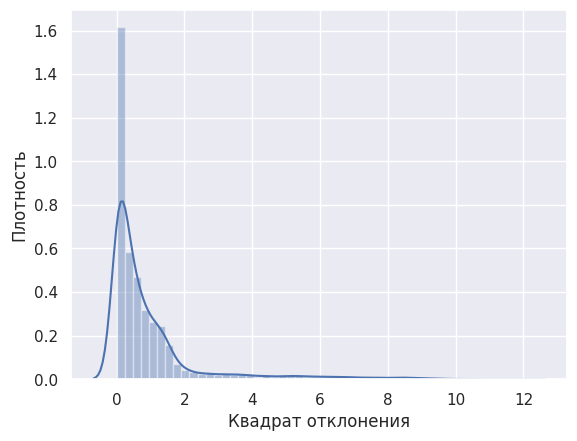

In [ ]:
error = (y_train - reg.predict(X_train_scaled)) ** 2
sns.distplot(error)
plt.xlabel("Квадрат отклонения")
plt.ylabel("Плотность")
plt.show()

Как видно, есть несколько объектов, на которых модель ошибается сильно. Давайте посмотрим на качество, если удалить эти объекты из обучающей выборки.

In [ ]:
mask = (error < np.quantile(error, 0.99))
reg.fit(X_train_scaled[mask], y_train[mask])
y_pred = reg.predict(X_test_scaled)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.9717


Таким образом, можно улучшить качество линейной регрессии, если удалить из обучающей выборки выбросы. В данном примере, качество улучшилось не так сильно, но бывают ситуации, когда чистка обучающей выборки по ошибке, приводит к сильному улучшению качества.

Обратим внимание на веса модели. Почти все из них занулились! Это большое преимущество, так как разреживание весов позволяет отбирать нужные признаки, делая модель более лёгкой.

In [ ]:
reg.coef_

array([ 0.30658523,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ])

А теперь обучим с $l_2$ регуляризацией.

In [ ]:
reg = Ridge(alpha=0.5)
reg.fit(X_train_scaled, y_train)
print(reg.coef_)

[ 0.82540051  0.12701227 -0.24066504  0.27101941 -0.00317096 -0.04117445
 -0.87312407 -0.84556157]


Как видим, веса не разрежены, хотя и есть очень маленькие значения

### **Вопрос 11** (2 балла)

Приведите пример, когда линейная регрессия с $l_2$ регуляризацией гарантированно занулит какой-нибудь признак?

**Ваш ответ здесь**

In [ ]:
np.random.seed(1)

X5_train = np.random.randint(1000, size=1000)
X5_train = np.hstack((np.random.rand(1000)[:, None], X5_train[:, None]))
Y5_train = X5_train[:, 1] * 3 + X5_train[:, 0]

for alpha in [0, 1, 5, 10, 25, 50, 100]:

  reg = Ridge(alpha=alpha, max_iter=10000, tol=1e-5)
  reg.fit(X5_train, Y5_train)
  print(alpha, reg.coef_)

0 [1. 3.]
1 [0.9881839  2.99999944]
5 [0.94358554 2.99999734]
10 [0.8931956  2.99999494]
25 [0.76985491 2.99998898]
50 [0.62581526 2.99998174]
100 [0.45538886 2.99997243]


------

При обучении мы заранее не знаем, какое значение параметра регуляризации даст наилучшие результаты. Подобрать оптимальные параметры можно с помощью кросс-валидации. В sklearn есть несколько классов со встроенной кросс-валидацией

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

Воспользуемся классом GridSearch для перебора параметров по сетке.

* Для линейных регрессий перебирается параметр $\alpha$ - сила регуляризации. Обычно важнее перебирать порядок этого параметра, а не точное его значение. В силу этого сетку перебора будет удобно сделать через функцию np.logspace, например np.logspace(-3, 3, 10).

### Вопрос 12 (2 балла)

Воспользуйтесь классом [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) и подберите константы регуляризации для Lasso и Ridge регрессий. Измерьте качество обученных моделей. Сетка перебора должна быть логарифмической, из хотя бы 10 значений


**Подсказка:**
* Пример, как можно перебирать параметры в GridSearch у вложенных [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) можно [найти вот тут](https://www.kaggle.com/code/ilnazsalimov/gridsearch-with-pipeline)
* Обратите внимание, что сейчас мы сразу заносим масштабирование в Pipeline - чтобы иметь возможность сразу вызываться от оригинальных X_train, а также чтобы не было утечки данных при использовании GridSearch
* В GridSearch в качестве скоринговой функции можно подавать строковое описание функции из sklearn, которое [можно посмотреть вот тут](https://scikit-learn.org/stable/modules/model_evaluation.html), а также саму скоринговую функцию из sklearn или собственную функцию, сделанную [через make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer)

**Замечание:** Итоговое качество должно быть не больше 0.73 RMSE.

In [ ]:
model_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", Lasso())
])

model_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", Ridge())
])

lasso_cv = GridSearchCV(
    model_lasso,
    cv=5,
    scoring="neg_root_mean_squared_error",
    param_grid = {"regr__alpha": np.logspace(-4, 4, 10)}
)

ridge_cv = GridSearchCV(
    model_ridge,
    cv=5,
    scoring="neg_root_mean_squared_error",
    param_grid = {"regr__alpha": np.logspace(-4, 4, 10)}
)

lasso_cv.fit(X_train, y_train)
ridge_cv.fit(X_train, y_train)

print(f'Best Lasso Regression:\nalpha={lasso_cv.best_params_["regr__alpha"]}, score={mean_squared_error(y_test, lasso_cv.predict(X_test), squared=False)}')
print()
print(f'Best Ridge Regression:\nalpha={ridge_cv.best_params_["regr__alpha"]}, score={mean_squared_error(y_test, ridge_cv.predict(X_test), squared=False)}')

Best Lasso Regression:
alpha=0.005994842503189409, score=0.7266292124407095

Best Ridge Regression:
alpha=21.54434690031882, score=0.7235736713783821


Убедимся, что Lasso всё ещё зануляет признаки (скорее всего модель Lasso занулила хотя бы один).

In [ ]:
lasso_cv.best_estimator_.named_steps["regr"].coef_

array([ 0.79556787,  0.1311457 , -0.16587309,  0.1959776 , -0.        ,
       -0.03514261, -0.80994698, -0.77840303])

**Выводы** В первой части задания по линейным моделям мы должны были узнать:
.

1.   Зачем нужна регуляризация.
2.   Как отбирать значащие признаки.
3.   Когда линейные модели работают хорошо, а когда плохо

-----
<font color="white" style="opacity:0.2023"></font>

Во **второй части** мы будем применять линейные модели для классификации реальных данных, где мы сможем проверить наши выводы, полученные на искуственных примерах. А также убедимся в полезности нормировки и научимся работать с разными видами данных.
